Run cells one by one, enter huggingface token when asked.


Account should be able to freely access: https://huggingface.co/CompVis/stable-diffusion-v1-4

In [1]:
!pip install diffusers transformers gradio scipy ftfy "ipywidgets>=7,<8"

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
import gradio as gr
from diffusers import  StableDiffusionXLInpaintPipeline

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load SDXL inpainting pipeline
pipe = StableDiffusionXLInpaintPipeline.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    variant="fp16" if device == "cuda" else None,
    use_safetensors=True,
).to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [5]:
import torch
import requests
from io import BytesIO
from PIL import Image
from diffusers import StableDiffusionXLInpaintPipeline

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

# Download sample image and mask
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

image = download_image(img_url).resize((1024, 1024))
mask_image = download_image(mask_url).resize((1024, 1024))

# Load SDXL Inpainting pipeline
pipe = StableDiffusionXLInpaintPipeline.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
).to("cuda")

# Generate multiple samples
prompt = "a mecha robot sitting on a bench"
guidance_scale = 7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0)

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples
).images

# Show as grid
images.insert(0, image)  # original image for comparison
grid = image_grid(images, 1, num_samples + 1)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/49 [00:00<?, ?it/s]

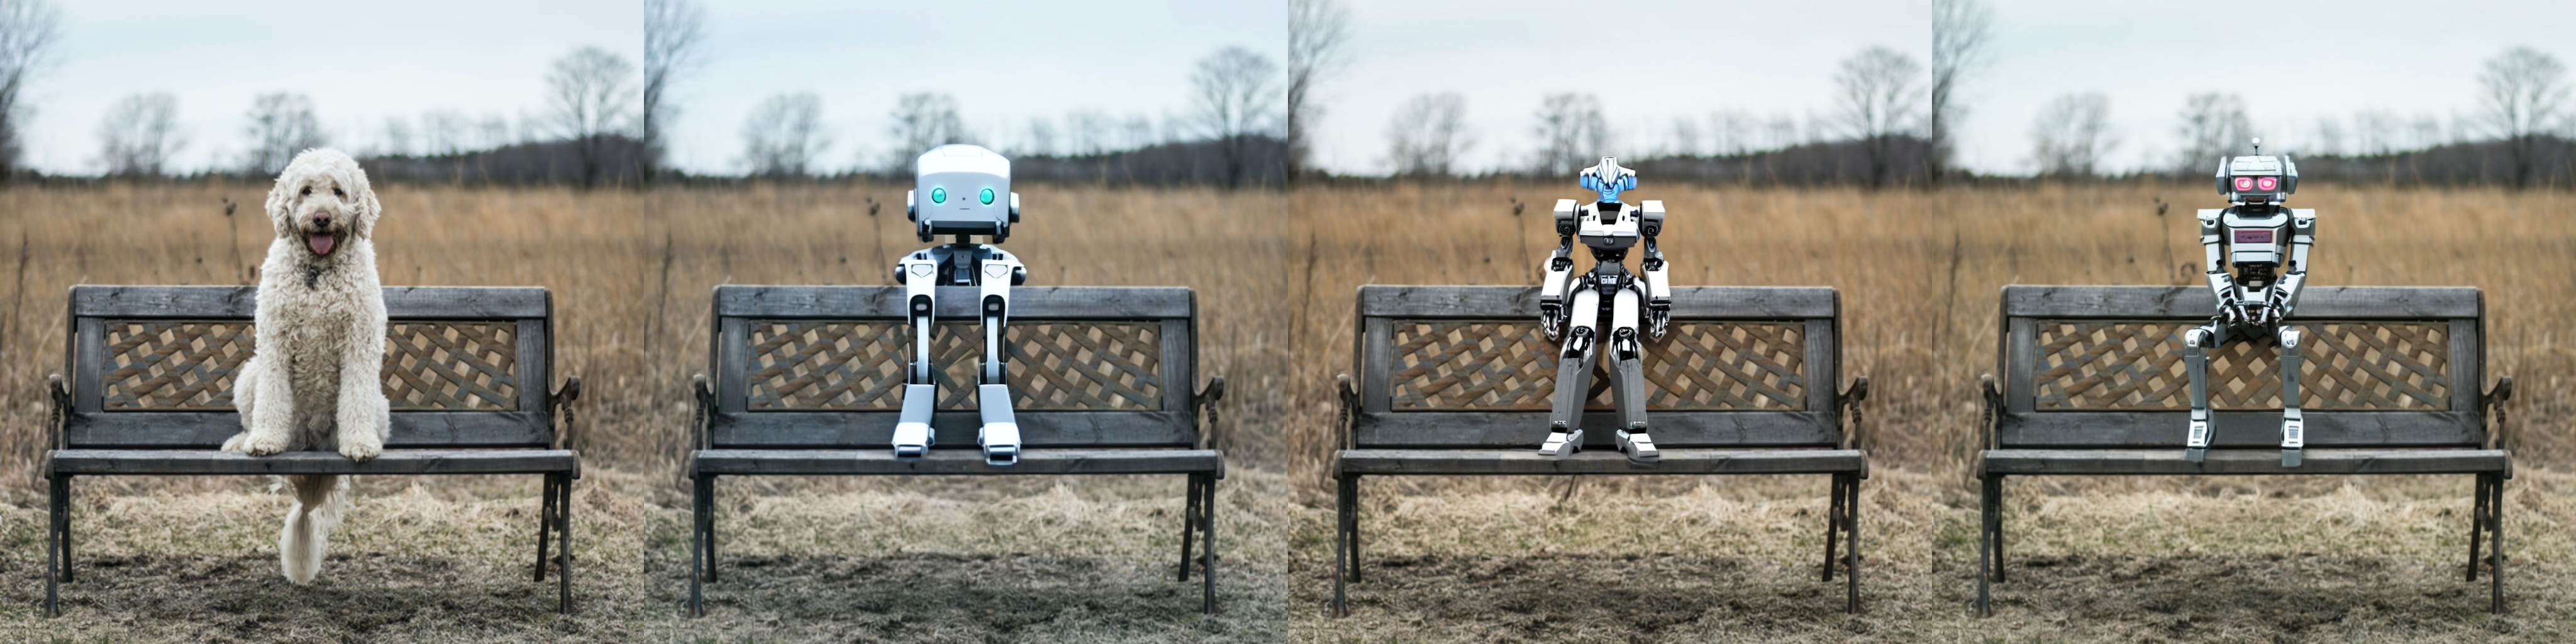

In [6]:
from IPython.display import display
display(grid)

In [7]:
# Inference function for Gradio
def predict(data, prompt):
    print("DATA RECEIVED:", data)

    image = Image.fromarray(data["background"]).convert("RGB").resize((1024, 1024))
    mask = Image.fromarray(data["layers"][0]).convert("L").resize((1024, 1024))

    # Binarize the mask
    mask = mask.point(lambda p: 255 if p > 10 else 0)

    result = pipe(
        prompt=prompt,
        image=image,
        mask_image=mask,
        guidance_scale=7.5,
        num_inference_steps=50,
    ).images[0]
    return result

In [ ]:
# Gradio interface
gr.Interface(
    fn=predict,
    inputs=[
        gr.ImageEditor(label="Upload + Draw Mask"),
        gr.Textbox(label="Prompt (e.g. 'replace with a mountain')"),
    ],
    outputs=gr.Image(label="Inpainted Output"),
).launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2b5e25c45fb2b51a78.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


DATA RECEIVED: {'background': array([[[164, 184, 193, 255],
        [173, 191, 202, 255],
        [190, 205, 215, 255],
        ...,
        [222, 232, 241, 255],
        [222, 232, 241, 255],
        [222, 232, 241, 255]],

       [[165, 185, 193, 255],
        [175, 193, 204, 255],
        [191, 206, 217, 255],
        ...,
        [222, 232, 241, 255],
        [222, 232, 241, 255],
        [222, 232, 241, 255]],

       [[169, 187, 196, 255],
        [178, 194, 206, 255],
        [192, 205, 217, 255],
        ...,
        [222, 232, 241, 255],
        [223, 233, 242, 255],
        [223, 233, 242, 255]],

       ...,

       [[175, 167, 152, 255],
        [151, 144, 127, 255],
        [164, 157, 138, 255],
        ...,
        [112, 108,  98, 255],
        [ 72,  72,  66, 255],
        [115, 115, 113, 255]],

       [[170, 166, 151, 255],
        [137, 132, 123, 255],
        [107, 101,  86, 255],
        ...,
        [122, 117, 106, 255],
        [125, 125, 117, 255],
        [145, 

  0%|          | 0/49 [00:00<?, ?it/s]